In [1]:
import trafpy
import trafpy.generator as tpg

import os
import pickle
import matplotlib.pyplot as plt

path_to_benchmark_data = os.path.dirname(trafpy.__file__)+'/../data/small_university_benchmark_testbed_v3.obj'
filehandler = open(path_to_benchmark_data, 'rb')
tb_dict = pickle.load(filehandler)

print(tb_dict.keys())

dict_keys(['benchmark_data', 'benchmarks', 'envs', 'config'])


In [2]:
envs = tb_dict['envs']
print(envs)

[<trafpy.manager.src.simulators.dcn.DCN object at 0x7fc3c00c7e50>, <trafpy.manager.src.simulators.dcn.DCN object at 0x7fc2cff3c460>, <trafpy.manager.src.simulators.dcn.DCN object at 0x7fc2cfbcca30>, <trafpy.manager.src.simulators.dcn.DCN object at 0x7fc2cf778490>, <trafpy.manager.src.simulators.dcn.DCN object at 0x7fc2cf184220>, <trafpy.manager.src.simulators.dcn.DCN object at 0x7fc2ced5da30>, <trafpy.manager.src.simulators.dcn.DCN object at 0x7fc2ce9aba90>, <trafpy.manager.src.simulators.dcn.DCN object at 0x7fc2cf6458e0>, <trafpy.manager.src.simulators.dcn.DCN object at 0x7fc2ce06e850>, <trafpy.manager.src.simulators.dcn.DCN object at 0x7fc2cdb925b0>, <trafpy.manager.src.simulators.dcn.DCN object at 0x7fc2cd7ca490>, <trafpy.manager.src.simulators.dcn.DCN object at 0x7fc2cd210190>, <trafpy.manager.src.simulators.dcn.DCN object at 0x7fc2ccd0f160>, <trafpy.manager.src.simulators.dcn.DCN object at 0x7fc2ce4807f0>, <trafpy.manager.src.simulators.dcn.DCN object at 0x7fc2cbe60e80>, <trafpy.m

## TODO

### Key Stats to Compare
- Average flow completion time
- 99th percentile flow completion time
- Queue length
- Throughput

### Key Plots

In [3]:
for env in envs:
    print('Net capacity: {}'.format(env.network.graph['max_nw_capacity']))
    print(env.get_scheduling_session_summary(print_summary=True))

Net capacity: 528.0
-=-=-=-=-=-=-= Scheduling Session Ended -=-=-=-=-=-=-=
SUMMARY:
~* General Info *~
Simulation name: 'benchmark_university_load_0.1_repeat_0_scheduler_srpt'
Total session duration: 6270000.0 time units
Total number of generated demands (jobs or flows): 177
Total info arrived: 597314.0 info units
Load: 0.09532760455467906 info unit demands arrived per unit time (from first to last flow arriving)
Total info transported: 597314.0 info units
Throughput: 0.09526539074960128 info units transported per unit time

~* Flow Info *~
Total number generated flows (src!=dst,dependency_type=='data_dep'): 177
Time first flow arrived: 17086.0 time units
Time last flow arrived: 6282994.0 time units
Time first flow completed: 27086.0 time units
Time last flow completed: 6287086.0 time units
Total number of demands that arrived and became flows: 177
Total number of flows that were completed: 177
Total number of dropped flows + flows in queues at end of session: 0
Average FCT: 6397.19209

In [4]:
# collect testbed stats into dict
testbed_stats = {'test_{}'.format(i): 
                 {envs[i].scheduler.scheduler_name: 
                  {'load': envs[i].load, 
                   'avrg_fct': envs[i].avrg_fct,
                   'nn_fct': envs[i].nn_fct}
                 } for i in range(len(envs))}

# find classes
classes = []
for test in testbed_stats.keys():
    for _class in testbed_stats[test].keys():
        if _class not in classes:
            classes.append(_class)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


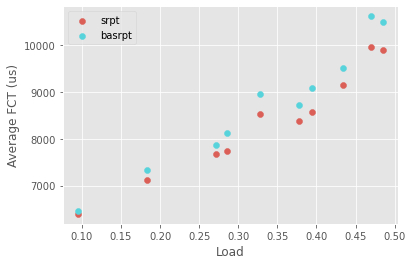

In [25]:
# avrg fct
plot_dict = {_class: {'x_values': [], 'y_values': []} for _class in classes}

for test in testbed_stats.keys():
    _class = list(testbed_stats[test].keys())[0]
    plot_dict[_class]['x_values'].append(testbed_stats[test][_class]['load'])
    plot_dict[_class]['y_values'].append(testbed_stats[test][_class]['avrg_fct'])

fig = tpg.plot_val_scatter(plot_dict=plot_dict,xlabel='Load', ylabel='Average FCT (us)', show_fig=True)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


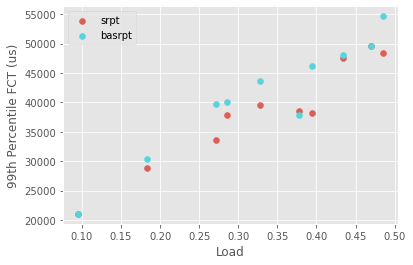

In [5]:
# 99th percentile fct
plot_dict = {_class: {'x_values': [], 'y_values': []} for _class in classes}

for test in testbed_stats.keys():
    _class = list(testbed_stats[test].keys())[0]
    plot_dict[_class]['x_values'].append(testbed_stats[test][_class]['load'])
    plot_dict[_class]['y_values'].append(testbed_stats[test][_class]['nn_fct'])

fig = tpg.plot_val_scatter(plot_dict=plot_dict,xlabel='Load', ylabel='99th Percentile FCT (us)', show_fig=True)

In [6]:
# queue length
import numpy as np

a = {key: None for key in np.array([1,2,3])}
b = {float(key): None for key in a.keys()}
print(b)
types1 = [type(key) for key in a.keys()]
types2 = [type(key) for key in b.keys()]

print(types1)
print(types1[0])
print(types2)

print(b.items())

{1.0: None, 2.0: None, 3.0: None}
[<class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>]
<class 'numpy.int64'>
[<class 'float'>, <class 'float'>, <class 'float'>]
dict_items([(1.0, None), (2.0, None), (3.0, None)])
